# Predicting the Survival of New Businesses in Vancouver

In [1]:
# preprocessing
from DataPreprocess import *
from DataFetch import fetch_business_license, fetch_econ_indicators
import pandas as pd
import numpy as np

# viz
import altair as alt
alt.data_transformers.enable("vegafusion")
alt.renderers.enable('svg')
import matplotlib.pyplot as plt

#sklearn tool
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate

# Preprocess / transform
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# models
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression

## Summary
This analysis aims to predict the survival of new businesses in Vancouver by examining various economic and demographic factors. Using datasets from the City business license registry (City of Vancouver 2023) and other external sources (Statistics Canada 2023), we explore the influence of location, industry, and economic indicators on business survival.

## Introduction
Vancouver's dynamic business landscape is influenced by various factors, including economic cycles, demographic shifts, and urban planning. Predicting the survival of new businesses in this environment is crucial for policymakers and entrepreneurs alike. This project seeks to answer: "Can the survival of a new business in Vancouver be predicted?" We utilize datasets from Vancouver's open data portal and integrate external data such as economic indicators and census data.
We are using the following Python packages to perform the analysis: Pandas (McKinney 2010), altair (VanderPlas, 2018), scikit-learn (Pedregosa et al. 2011).

### Dataset Description
The primary dataset comes from the City of Vancouver's business license registry, updated as businesses are licensed, renew, or terminate. This dataset is enriched with external data, including economic indicators.




## Loading dataset & Preprocessing

In [2]:
# Fetch data by urls --> already modulized in DataFetch.py
business = fetch_business_license()
raw_econ_index_data_dict = fetch_econ_indicators()

Now loading: business_license data
Now loading: GDP data
Now loading: ConsumerPrice data
Now loading: Employment data
Now loading: InvestmentConstruction data


### Business Lisence data
#### Clean-up
- Drop rows where `ExpiredDate` and `IssuedDate` are NA.
- Transform `ExpiredDate` and `IssuedDate` to date.
- Calculate the survival interval of each company, which is the difference between the maximum of ExpiredDate and the minimum of IssuedDate.
- Keep only the newest issued record of each company.
- Filter to keep those records where the latest `ExpiredDate` is before or equal to year 2022 because for those licenses issued in year 2023, the dafault `ExpiredDate` are `2023-12-31` and we cannot know whether it would survive until then.

#### Response Variable for Classification: survival_status
- Since about half of the companies in our dataset can survive over 2 years, to balance the amount of True & False, we set the threshold to 2 years 

In [3]:
# Drop rows where ExpiredDate and IssuedDate are NA
business = business_datacleaning(business = business, survival_threshold = 365 * 2)

### Macroeconomics Data
- Create a column `REF_YEAR` representing the year of `REF_DATE`
- Keep rows where `North American Industry Classification System (NAICS) == 'All industries'`, since it is time-consuming to manually map the `BusinessType` in business license dataset to the related industries, we will merely consider the overall GDP performance in this project.
- Keep rows where `REF_YEAR >= 2012`
- Keep columns `REF_YEAR` and `VALUE`

In [4]:
econ = econ_datacleaning(raw_econ_index_data_dict)

### Combine business lisence and macroeconomics data
- Map the yearly GDP value to the first lisence issued year of each company (the year when a company starts it business).

In [5]:
business_econ = merge_business_econ_by_year(business, econ)
business_econ.head()

,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,FeePaid,ExtractDate,Geom,geo_point_2d,survival_days,survival_status,GDPValue,ConsumerPriceValue,EmploymentValue,InvestmentConstructionValue
0,2015,2333488,15-103790,0,Hollyhock Properties Ltd,NaN,Issued,2014-12-03,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.116856730836, 49.2678622...","49.2678622929998, -123.116856730836",4048.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
1,2015,2333496,15-103798,0,(Zandra Paleczny),NaN,Issued,2014-11-06,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.133925222671, 49.2796620...","49.2796620031115, -123.133925222671",4045.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
2,2015,2333501,15-103803,0,(Dave Dixon),NaN,Issued,2014-11-14,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.124998311257, 49.2836868...","49.2836868407842, -123.124998311257",2208.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
3,2015,2333502,15-103804,0,Henry B Yuen (Henry Yuen),NaN,Issued,2014-12-05,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.132003087572, 49.2741705...","49.2741705397492, -123.132003087572",4007.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
4,2015,2333506,15-103808,0,Tsang & Lee Enterprises Inc,NaN,Issued,2015-01-07,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.117431658016, 49.2687000...","49.2687000536747, -123.117431658016",4015.0,1,1.820026e+06,1.9,2390.0,1.146144e+09


## EDA & Visualization

Overall Target: To look at which of the features might be useful to predict the survival status, we plotted the distributions of each predictor from the dataset and coloured the distribution by class (failed to survive more than 2 yrs: green, and survived for more than 2 yrs: orange). In doing this, what we aim at is to omit features of which both the binary classes have similar patterns. In that way, it means that these features do have the power to tell the two classes apart and fit their values into each of them.

In [6]:
business_econ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92317 entries, 0 to 92316
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FOLDERYEAR                   92317 non-null  object 
 1   LicenceRSN                   92317 non-null  int64  
 2   LicenceNumber                92317 non-null  object 
 3   LicenceRevisionNumber        92317 non-null  int64  
 4   BusinessName                 92316 non-null  object 
 5   BusinessTradeName            39481 non-null  object 
 6   Status                       92317 non-null  object 
 7   IssuedDate                   92317 non-null  object 
 8   ExpiredDate                  92317 non-null  object 
 9   BusinessType                 92317 non-null  object 
 10  BusinessSubType              54209 non-null  object 
 11  Unit                         25323 non-null  object 
 12  UnitType                     25301 non-null  object 
 13  House           

In [7]:
business.describe(include='all')

,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,Country,PostalCode,LocalArea,NumberofEmployees,FeePaid,ExtractDate,Geom,geo_point_2d,survival_days,survival_status
count,92317,9.231700e+04,92317,92317.000000,92316,39481,92317,92317,92317,92317,...,92013,48020,78638,92317.000000,91877.000000,92317,47063,47063,92316.000000,92317.000000
unique,10,NaN,91890,NaN,92316,33736,5,3153,674,175,...,1,5940,22,NaN,NaN,62,8115,8115,NaN,NaN
top,2018,NaN,15-217629,NaN,Hollyhock Properties Ltd,Lawson Lundell LLP,Issued,2013-01-09,2018-12-31,Office,...,CA,V5Z 4C2,Downtown,NaN,NaN,2020-01-01T02:32:02-08:00,"{""coordinates"": [-123.119500778402, 49.2822434...","49.2822434350563, -123.119500778402",NaN,NaN
freq,14218,NaN,3,NaN,1,116,86494,446,14109,16142,...,92013,270,20513,NaN,NaN,4087,338,338,NaN,NaN
mean,NaN,2.910343e+06,NaN,0.027633,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.839943,260.559498,NaN,NaN,NaN,1885.745797,0.720420
std,NaN,6.387908e+05,NaN,0.168996,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2465.594665,818.771910,NaN,NaN,NaN,1377.073977,0.448795
min,NaN,1.771189e+06,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,-147.000000,0.000000
25%,NaN,2.474722e+06,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,129.000000,NaN,NaN,NaN,668.000000,0.000000
50%,NaN,3.003809e+06,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,151.000000,NaN,NaN,NaN,1496.000000,1.000000
75%,NaN,3.370692e+06,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.000000,187.000000,NaN,NaN,NaN,3236.000000,1.000000


### Numeric Features

We start with numeric features. By deleting features that make no sense or have limited value to dig into, we picked 6 numeric features to implement EDA on. 

With the generated figures, we found out that patterns of all the numeric features of the two classes look very similar in the pattern. Thus, we choose to omit all of these from our model.


In [8]:
numeric_features = ['GDPValue', 'ConsumerPriceValue', 'EmploymentValue', 'InvestmentConstructionValue'] 
# Save Numberofemployees and FeePaid for later due to their large variance

In [9]:
# Create a chart object for each feature.
charts_numeric = [alt.Chart(business_econ).transform_density(
    feature,
    as_=[feature, 'density'],
    groupby=['survival_status']
).mark_area(opacity=0.5).encode(
    x=alt.X(feature, title=feature).stack(False),
    y='density:Q',
    color=alt.Color('survival_status:O').scale(scheme='dark2')
).properties(
    width=180,
    height=120
) for feature in numeric_features]


# Combine the charts.
chart_grid = alt.vconcat(*[
    alt.hconcat(*charts_numeric[i:i+2]) for i in range(0, len(charts_numeric), 2)
])


In [10]:
employee = alt.Chart(business_econ[['NumberofEmployees', 'survival_status']]).transform_density(
    'NumberofEmployees',
    as_=['NumberofEmployees', 'density'],
    groupby=['survival_status']
).mark_area(opacity=0.5).encode(
    x=alt.X('NumberofEmployees', title='NumberofEmployees', scale=alt.Scale(domain=[0, 5000])).stack(False),
    y='density:Q',
    color=alt.Color('survival_status:O').scale(scheme='dark2')
).properties(
    width=120,
    height=120
)

In [11]:
feepaid = alt.Chart(business_econ).transform_density(
    'FeePaid',
    as_=['FeePaid', 'density'],
    groupby=['survival_status']
).mark_area(opacity=0.5).encode(
    x=alt.X('FeePaid', title='FeePaid', scale=alt.Scale(domain=[0, 5000])).stack(False),
    y='density:Q',
    color=alt.Color('survival_status:O').scale(scheme='dark2')
).properties(
    width=120,
    height=120
)

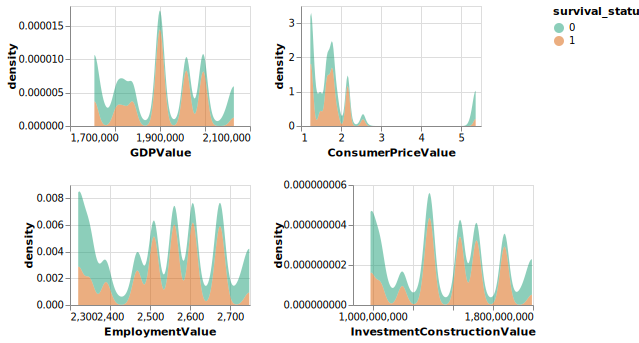

In [12]:
chart_grid

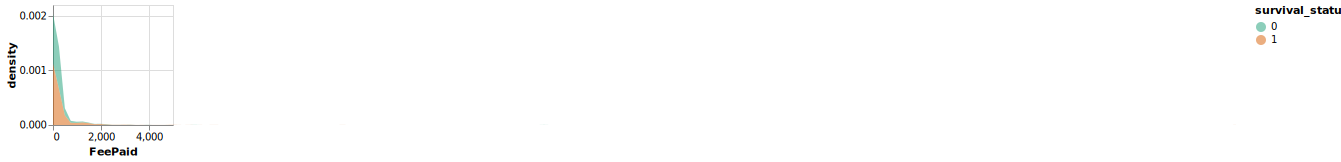

In [13]:
# employee & feepaid
feepaid

### Caregorical Features

For categorical features we generated histograms to see frequency of observations of both classes. 

The two histograms indicate an underlying pattern where the two features could have an influence on the target, with the similar spread of frequencies.

In [14]:
business_econ['City'].value_counts() # With significantly large proportion of data in Vancouver, we would focus our research only on Vancouver
business_econ['Province'].value_counts() # Since most of the data are in BC Province, we would look into records in BC.

categorical_features = ['LocalArea', 'BusinessType'] 

In [15]:
local = alt.Chart(business_econ).mark_bar(opacity=0.5).encode(
    alt.X('LocalArea', sort='-y').stack(False),
    y='count()',
    color=alt.Color('survival_status:O').scale(scheme='dark2')
).facet(
    'survival_status:O', columns = 2
)

In [16]:
business_econ['BusinessType'].value_counts()

BusinessType
Office                     16142
Contractor                  6581
Retail Dealer               5205
Health Services             4977
Apartment House Strata      3927
                           ...  
Dairy Delivery Services        1
Public Market - Daily          1
Short-Term Rental              1
Motel                          1
Piano Tuner                    1
Name: count, Length: 175, dtype: int64

In [17]:
top_20_businesstype = business_econ['BusinessType'].value_counts().head(20).index.tolist()

# Filter to include only the top 20 business types
filtered = business_econ[business_econ['BusinessType'].isin(top_20_businesstype)]

businesstype = alt.Chart(filtered).mark_bar(opacity=0.5).encode(
    x=alt.X('BusinessType:N', sort='-y'),
    y='count()',
    color=alt.Color('survival_status:O', scale=alt.Scale(scheme='dark2'))
).facet(
    column='survival_status:O',
    columns=2
)

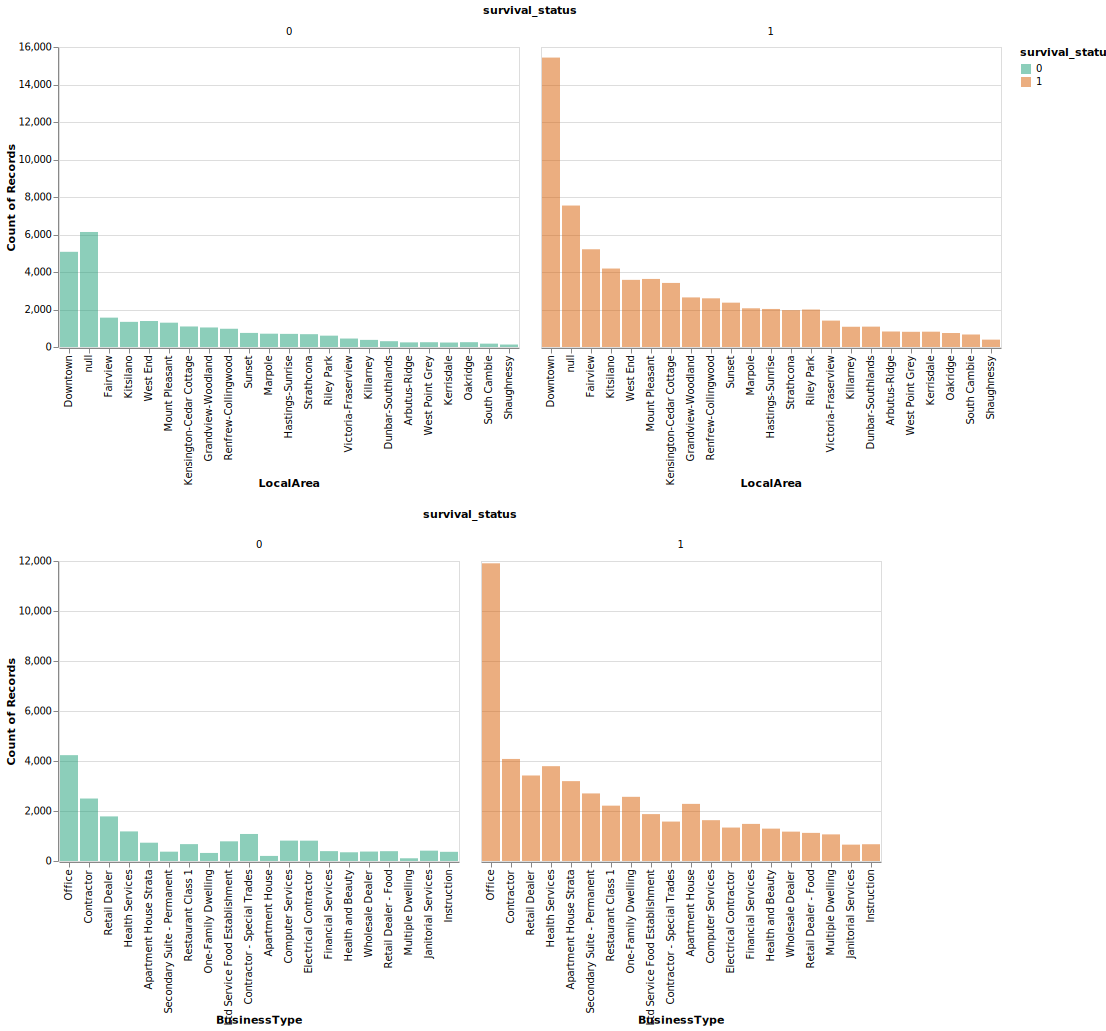

In [18]:
local & businesstype

### Analysis

We have used Logistic Regression and BernoulliNB for predicting business survival in Vancouver due to the nature of the data. 

##### Why Logistic Regression and BernoulliNB?
Logistic Regression is effective when the outcome is binary, making it appropriate for predicting whether a business survives or not. Easier interpretability of the model results is another reason why we chose Logistic Regression. It's a linear model that provides coefficients for each predictor variable, making it easy to interpret the impact of each variable on the predicted outcome. This can be crucial for understanding the economic and demographic factors influencing business survival. 

BernoulliNB, a variant of Naive Bayes, accommodates binary outcomes, aligning with the nature of the task where businesses either survive or fail. It excels in handling categorical features and is effective in scenarios with sparse data, making it well-suited for the diverse and potentially sparse economic and demographic factors influencing business longevity in the city.

##### Train Test Split
We are using 70% of our data as training data and the remaining 30% is used as test data.


##### Results
Logistic Regression is performing better and we are getting a cross-validation accuracy of ~80% (79.2%) on whether a business will survive or not. BernoulliNB has slightly lower cross-validation accuracy of 74.6%.

In [19]:
# As the EDA part shows, with significantly large proportion of data in Vancouver, we would focus our research only on Vancouver
business = business[business['City'] == 'Vancouver']
business_econ = merge_business_econ_by_year(business, econ)
business_econ.head()

,FOLDERYEAR,LicenceRSN,LicenceNumber,LicenceRevisionNumber,BusinessName,BusinessTradeName,Status,IssuedDate,ExpiredDate,BusinessType,...,FeePaid,ExtractDate,Geom,geo_point_2d,survival_days,survival_status,GDPValue,ConsumerPriceValue,EmploymentValue,InvestmentConstructionValue
0,2015,2333488,15-103790,0,Hollyhock Properties Ltd,NaN,Issued,2014-12-03,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.116856730836, 49.2678622...","49.2678622929998, -123.116856730836",4048.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
1,2015,2333496,15-103798,0,(Zandra Paleczny),NaN,Issued,2014-11-06,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.133925222671, 49.2796620...","49.2796620031115, -123.133925222671",4045.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
2,2015,2333501,15-103803,0,(Dave Dixon),NaN,Issued,2014-11-14,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.124998311257, 49.2836868...","49.2836868407842, -123.124998311257",2208.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
3,2015,2333502,15-103804,0,Henry B Yuen (Henry Yuen),NaN,Issued,2014-12-05,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.132003087572, 49.2741705...","49.2741705397492, -123.132003087572",4007.0,1,1.820026e+06,1.9,2390.0,1.146144e+09
4,2015,2333506,15-103808,0,Tsang & Lee Enterprises Inc,NaN,Issued,2015-01-07,2015-12-31,Apartment House Strata,...,64.0,2019-07-21T13:49:14-07:00,"{""coordinates"": [-123.117431658016, 49.2687000...","49.2687000536747, -123.117431658016",4015.0,1,1.820026e+06,1.9,2390.0,1.146144e+09


In [20]:
def transform(df, word_features, categorical_features, numeric_features):
    # drop_features = ['Status', 'BusinessSubType', 'FOLDERYEAR', 'LicenceRSN', 'LicenceNumber', 'LicenceRevisionNumber',
    #     'BusinessName', 'BusinessTradeName', 'IssuedDate', 'ExpiredDate', 
    #     'Unit', 'UnitType', 'House', 'Street', 'ExtractDate', 'Geom', 'geo_point_2d']
    
    word_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        FunctionTransformer(np.reshape, kw_args={'newshape':-1}),
        CountVectorizer(binary=True)
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown='ignore')
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler()
    )
    
    word_trans_arr = word_transformer.fit_transform(df[word_features])
    categorical_trans_arr = categorical_transformer.fit_transform(df[categorical_features])
    numeric_trans_arr = numeric_transformer.fit_transform(df[numeric_features])
    
    return np.hstack((word_trans_arr.toarray(), categorical_trans_arr, numeric_trans_arr))


In [21]:
train_df, test_df = train_test_split(business_econ, test_size=0.3, random_state=123)

word_features = ['BusinessType']
categorical_features = ['City', 'LocalArea']
numeric_features = ['NumberofEmployees', 'FeePaid', 
                     'GDPValue', 'ConsumerPriceValue', 'EmploymentValue', 'InvestmentConstructionValue']

X_train = train_df[word_features + categorical_features + numeric_features]
X_test = test_df[word_features + categorical_features + numeric_features]
y_train = train_df["survival_status"]
y_test = test_df["survival_status"]

X_train_transformed = transform(X_train, word_features, categorical_features, numeric_features)

In [22]:
bnb = BernoulliNB()
pd.DataFrame(cross_validate(bnb, X_train_transformed, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.062620,0.004942,0.751349,0.746051
1,0.056045,0.004544,0.746312,0.746311
2,0.053538,0.004246,0.747931,0.745532
3,0.052968,0.004307,0.740734,0.746211
4,0.055632,0.004223,0.743793,0.745792
5,0.054401,0.004200,0.741994,0.746231
6,0.057314,0.004579,0.745186,0.746736
7,0.055509,0.004778,0.741407,0.746716
8,0.059001,0.004284,0.744466,0.746836
9,0.062824,0.004403,0.746986,0.746996


In [23]:
logreg = LogisticRegression(random_state=123, max_iter=1000)
pd.DataFrame(cross_validate(logreg, X_train_transformed, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,4.363412,0.001050,0.790212,0.791455
1,4.110166,0.001057,0.795430,0.791675
2,4.702568,0.001045,0.790932,0.791835
3,3.941115,0.001269,0.786074,0.791675
4,4.335946,0.001049,0.787334,0.791815
5,4.462373,0.001134,0.794530,0.791275
6,4.277094,0.001161,0.795573,0.792199
7,4.544686,0.001060,0.791254,0.791399
8,4.471037,0.001193,0.785316,0.791979
9,3.961676,0.001101,0.788195,0.792259


In [24]:
X_test_transformed = transform(X_test, word_features, categorical_features, numeric_features)
logreg.fit(X_test_transformed, y_test)
logreg.score(X_test_transformed, y_test)

0.7907552793987993

#### Conclusion and Improvements

The Logistic Regression model gives a decent accuracy of ~80% here and can be used as an assistive model for making decisions on whether business licence will be renewed or not. 

We can further improve the model results:

- Trying out more complex models like Random Forest, Neural Networks etc. (which are currently out of our MDS syllabus scope as of now).
- By combining other economic and socio-economic factors in our dataset

## References

City of Vancouver. 2023. 'Business Licences Dataset.' Vancouver Open Data. https://opendata.vancouver.ca/explore/dataset/business-licences/information/?disjunctive.status&disjunctive.businesssubtype&refine.folderyear=23

Statistics Canada. 2023. https://www150.statcan.gc.ca/n1/en/type/data?MM=1

McKinney, Wes. 2010. “Data Structures for Statistical Computing in Python.” In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51–56.

VanderPlas, J. et al., 2018. Altair: Interactive statistical visualizations for python. Journal of open source software, 3(32), p.1057.

Pedregosa, F. et al., 2011. Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825–2830.